## Imports

In [36]:
import pandas as pd
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from sklearn.metrics import accuracy_score


### Load and process data

In [37]:
# Load data
df = pd.read_json('movies_balanced.json')
df.head()

,overview,genre
0,The life of the gambling paradise – Las Vegas ...,Drama
1,"Rich Mr. Dashwood dies, leaving his second wif...",Drama
2,An agoraphobic psychologist and a female detec...,Drama
3,Harassed by classmates who won't accept his sh...,Drama
4,"Ben Sanderson, an alcoholic Hollywood screenwr...",Drama


In [38]:

# Preprocessing text
def preprocess_text(s):
    s = re.sub(r'[^\w\s]', '', s)  # Remove punctuation
    s = s.lower()  # Lowercase text
    return s


df['overview'] = df['overview'].apply(preprocess_text)

top10categories = [
    "Drama",
    "Comedy",
    "Action",
    "Documentary",
    "Horror",
    "Crime",
    "Thriller",
    "Adventure",
    "Romance",
    "Animation"
]
df = df[df['genre'].isin(top10categories)]




### Initialize BERT tokenizer

In [39]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(texts):
    return tokenizer(texts, add_special_tokens=True, max_length=120, padding='max_length', truncation=True, return_tensors='pt')


### Tokenize all descriptions
Also insert input_ids and attention_mask into the dataset.

In [40]:
encoded_batch = tokenize_function(df['overview'].tolist())
df['input_ids'] = [tensor.squeeze() for tensor in encoded_batch['input_ids']]
df['attention_mask'] = [tensor.squeeze()
                        for tensor in encoded_batch['attention_mask']]

### Encode labels
Encodes the labels such as 'Action' or 'Commedy'

In [41]:
label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['genre'])

### Split data into training, validation, and test sets
Here we are going for a 80 percent training, 10 percent validation and 10 percent testing split.

In [42]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


### Create PyTorch dataset

In [43]:
class MovieDataset(Dataset):
    def __init__(self, entries):
        self.entries = entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries.iloc[idx]
        input_ids = entry['input_ids']
        attention_mask = entry['attention_mask']
        labels= torch.tensor(entry['labels'], dtype=torch.long)
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}


train_dataset = MovieDataset(train_df)
val_dataset = MovieDataset(val_df)
test_dataset = MovieDataset(test_df)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


### Load BERT model for sequence classification

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=len(label_encoder.classes_))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
 
lr = 5e-5  # 0.00005
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 3)

best_model = None
best_val_loss = float('inf')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
naked_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=len(label_encoder.classes_))
naked_model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Training and validation

In [47]:
import torch
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

best_val_loss = float('inf')

for epoch in range(5):
    # === Training Loop ===
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        batch = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    current_lr = scheduler.get_last_lr()[0]  # Get current learning rate

    # === Validation Loop ===
    model.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            batch = {k: v.to(model.device) for k, v in batch.items()}
            outputs = model(**batch)

            # Extract predictions and true labels
            logits = outputs.logits

            # Get predicted class for each sample
            predictions = torch.argmax(logits, dim=-1)

            # Assuming labels are stored under 'labels' in the batch
            labels = batch['labels']

            # Store predictions and labels for F1 score calculation
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            loss = outputs.loss
            total_val_loss += loss.item()

    val_loss = total_val_loss / len(val_loader)

    # Calculate F1, precision, recall, and accuracy
    # 'weighted' accounts for class imbalance
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()

    # Print out the metrics for the current epoch
    print(f"Epoch {epoch+1} Metrics:")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"F1 Score: {f1:.4f} | Precision: {precision:.4f} | Recall: {
          recall:.4f} | Accuracy: {accuracy:.4f}")
    print(f"Current Learning Rate: {current_lr:.6f}\n")

Validation Epoch 1: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]


Epoch 1 Metrics:
Train Loss: 1.6582 | Val Loss: 1.5428
F1 Score: 0.4399 | Precision: 0.4742 | Recall: 0.4500 | Accuracy: 0.4500
Current Learning Rate: 0.000040



Validation Epoch 2: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]


Epoch 2 Metrics:
Train Loss: 1.1241 | Val Loss: 1.4761
F1 Score: 0.4946 | Precision: 0.5105 | Recall: 0.4980 | Accuracy: 0.4980
Current Learning Rate: 0.000030



Validation Epoch 3: 100%|██████████| 63/63 [00:20<00:00,  3.03it/s]


Epoch 3 Metrics:
Train Loss: 0.6645 | Val Loss: 1.7162
F1 Score: 0.4823 | Precision: 0.4867 | Recall: 0.4860 | Accuracy: 0.4860
Current Learning Rate: 0.000020



Validation Epoch 4: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]


Epoch 4 Metrics:
Train Loss: 0.3086 | Val Loss: 2.0281
F1 Score: 0.4680 | Precision: 0.4827 | Recall: 0.4680 | Accuracy: 0.4680
Current Learning Rate: 0.000010



Validation Epoch 5: 100%|██████████| 63/63 [00:22<00:00,  2.83it/s]

Epoch 5 Metrics:
Train Loss: 0.1425 | Val Loss: 2.1215
F1 Score: 0.4798 | Precision: 0.4916 | Recall: 0.4760 | Accuracy: 0.4760
Current Learning Rate: 0.000000




# Load best model for evaluation

In [48]:

model.load_state_dict(best_model)
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        batch = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).tolist())
        actuals.extend(batch['labels'].tolist())


Evaluating: 100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


In [49]:
naked_model.eval()
predictions_naked, actuals_naked = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        batch = {k: v.to(naked_model.device) for k, v in batch.items()}
        outputs = naked_model(**batch)
        logits = outputs.logits
        predictions_naked.extend(torch.argmax(logits, dim=-1).tolist())
        actuals_naked.extend(batch['labels'].tolist())

Evaluating: 100%|██████████| 63/63 [00:22<00:00,  2.81it/s]



# Calculate accuracy
finetuned model:

In [50]:

accuracy = accuracy_score(actuals, predictions)
print(f'Accuracy: {accuracy:.4f}')  # Print the accuracy with 4 decimal places

Accuracy: 0.4770


Naked model

In [51]:
accuracy_naked = accuracy_score(actuals_naked, predictions_naked)
print(f'Accuracy: {accuracy_naked:.4f}')  # Print the accuracy with 4 decimal places

Accuracy: 0.0890



### Generate classification report and modify index to show genre names

In [52]:
report = pd.DataFrame(classification_report(
    actuals, predictions, output_dict=True)).transpose()
report_naked = pd.DataFrame(classification_report(
    actuals_naked, predictions_naked, output_dict=True)).transpose()

/Users/oskarnesheim/Documents/final_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/oskarnesheim/Documents/final_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/oskarnesheim/Documents/final_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

### Remove the 'accuracy' row if it's present

In [53]:

# report.drop(['accuracy'], inplace=True) #? Hvorfor gjør vi dette?
# report['support'] = report['support'].apply(int)


### Map numeric labels back to string names using LabelEncoder

In [54]:

report.index = [label_encoder.inverse_transform(
    [int(idx)])[0] if idx.isdigit() else idx for idx in report.index]
report_naked.index = [label_encoder.inverse_transform(
    [int(idx)])[0] if idx.isdigit() else idx for idx in report.index]


### Visualization of the Classification Report

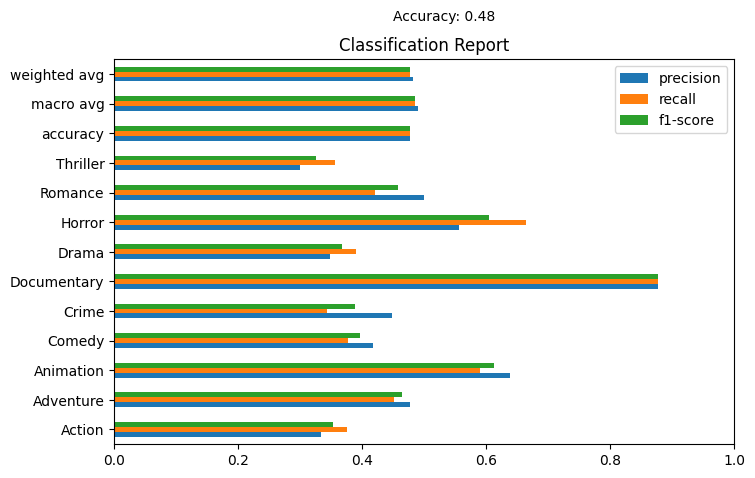

In [55]:
fig, ax = plt.subplots(figsize=(8, 5))
report[['precision', 'recall', 'f1-score']].plot(kind='barh', ax=ax)
ax.text(0.45, 1.1, f'Accuracy: {accuracy:.2f}', transform=ax.transAxes)
ax.set_title('Classification Report')
ax.set_xlim([0, 1])
plt.show()

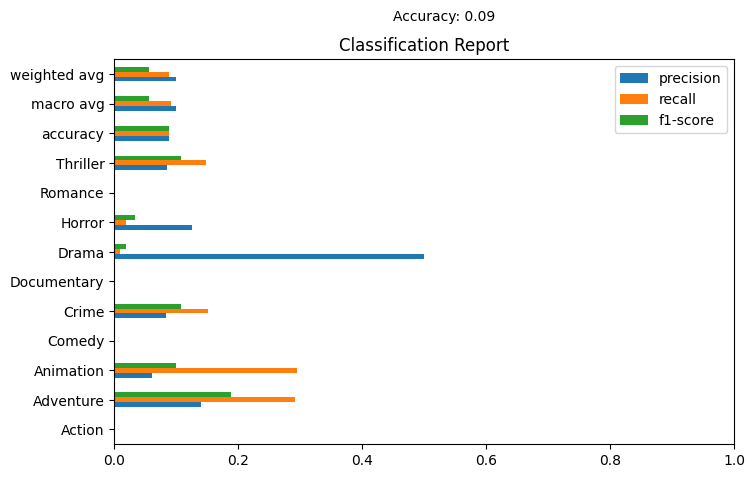

In [56]:

fig, ax = plt.subplots(figsize=(8, 5))
report_naked[['precision', 'recall', 'f1-score']].plot(kind='barh', ax=ax)
ax.text(0.45, 1.1, f'Accuracy: {accuracy_naked:.2f}', transform=ax.transAxes)
ax.set_title('Classification Report')
ax.set_xlim([0, 1])
plt.show()


### Confusion Matrix with genre names

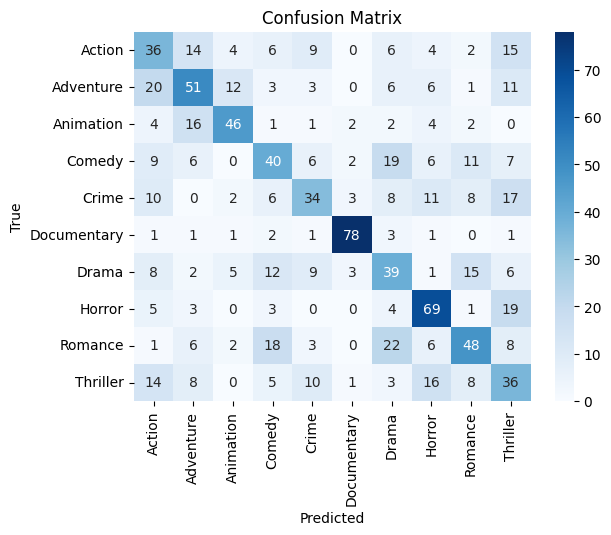

In [57]:

conf_mat = confusion_matrix(actuals, predictions)
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [58]:
# Oppdatere denne slik at vi får lik data som i presentasjonen.
print(classification_report(actuals, predictions))

              precision    recall  f1-score   support

           0       0.33      0.38      0.35        96
           1       0.48      0.45      0.46       113
           2       0.64      0.59      0.61        78
           3       0.42      0.38      0.40       106
           4       0.45      0.34      0.39        99
           5       0.88      0.88      0.88        89
           6       0.35      0.39      0.37       100
           7       0.56      0.66      0.61       104
           8       0.50      0.42      0.46       114
           9       0.30      0.36      0.33       101

    accuracy                           0.48      1000
   macro avg       0.49      0.48      0.48      1000
weighted avg       0.48      0.48      0.48      1000



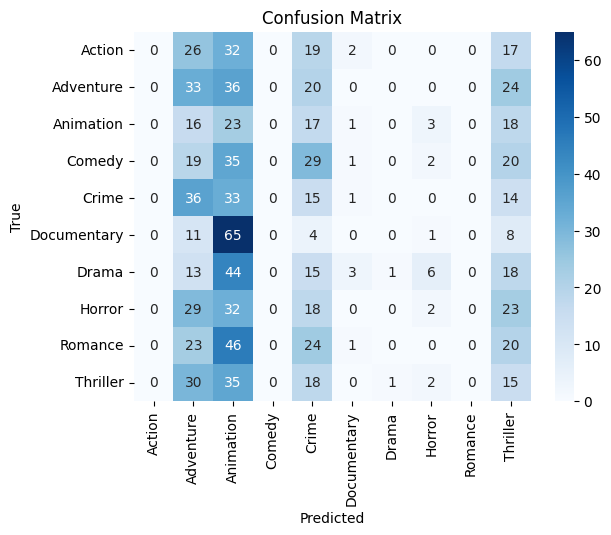

In [59]:

conf_mat = confusion_matrix(actuals_naked, predictions_naked)
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [60]:
print(classification_report(actuals_naked, predictions_naked))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.14      0.29      0.19       113
           2       0.06      0.29      0.10        78
           3       0.00      0.00      0.00       106
           4       0.08      0.15      0.11        99
           5       0.00      0.00      0.00        89
           6       0.50      0.01      0.02       100
           7       0.12      0.02      0.03       104
           8       0.00      0.00      0.00       114
           9       0.08      0.15      0.11       101

    accuracy                           0.09      1000
   macro avg       0.10      0.09      0.06      1000
weighted avg       0.10      0.09      0.06      1000



/Users/oskarnesheim/Documents/final_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/oskarnesheim/Documents/final_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/oskarnesheim/Documents/final_project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa